## Interactive subspaces

This notebook let you to gaze subspaces we learn with an interactive UMAP.

In [6]:
import json
import torch
import pandas as pd
import altair as alt
from umap import UMAP
from plotnine import *

In [2]:
def load_jsonl(filepath):
    """Example JSONL loading function."""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def get_genre(metadata_entry):
    """Returns the genre string ('text', 'code', or 'math')."""
    concept_name = metadata_entry['concept']
    return metadata_entry['concept_genres_map'][concept_name][0]

In [3]:
lsreft = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_metadata = load_jsonl("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_lsreft/train/metadata.jsonl")
assert lsreft.shape[0] == len(lsreft_metadata)

diffmean = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_diffmean/train/DiffMean_weight.pt")
diffmean_metadata = load_jsonl("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_diffmean/train/metadata.jsonl")
assert diffmean.shape[0] == len(diffmean_metadata)
assert lsreft.shape[0] == diffmean.shape[0]

/tmp/aryaman/ipykernel_3899783/3325168309.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lsreft = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_conce

In [26]:
umap_lsreft = UMAP(n_components=2, random_state=42).fit_transform(lsreft.float().numpy())
umap_diffmean = UMAP(n_components=2, random_state=42).fit_transform(diffmean.float().numpy())

df_lsreft = pd.DataFrame({
    'x': umap_lsreft[:, 0],
    'y': umap_lsreft[:, 1],
    'concept': [m['concept'] for m in lsreft_metadata],    # or any other field
    'genre':   [get_genre(m) for m in lsreft_metadata],
    'method':  'LsReFT'
})
df_diffmean = pd.DataFrame({
    'x': umap_diffmean[:, 0],
    'y': umap_diffmean[:, 1],
    'concept': [m['concept'] for m in diffmean_metadata],
    'genre':   [get_genre(m) for m in diffmean_metadata],
    'method':  'DiffMean'
})
df_all = pd.concat(df_lsreft, ignore_index=True)

df_subsample = df_all.sample(n=2000, random_state=42)

alt.data_transformers.disable_max_rows()

chart = (
    alt.Chart(df_all)
    .mark_circle(size=30)
    .encode(
        x=alt.X('x:Q'),
        y=alt.Y('y:Q'),
        color=alt.Color('genre:N', legend=alt.Legend(title="Genre")),
        tooltip=['concept:N', 'method:N', 'genre:N']  # fields that appear on hover
    )
    .interactive()  # Allows panning & zooming
)

chart  # Display in Jupyter

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

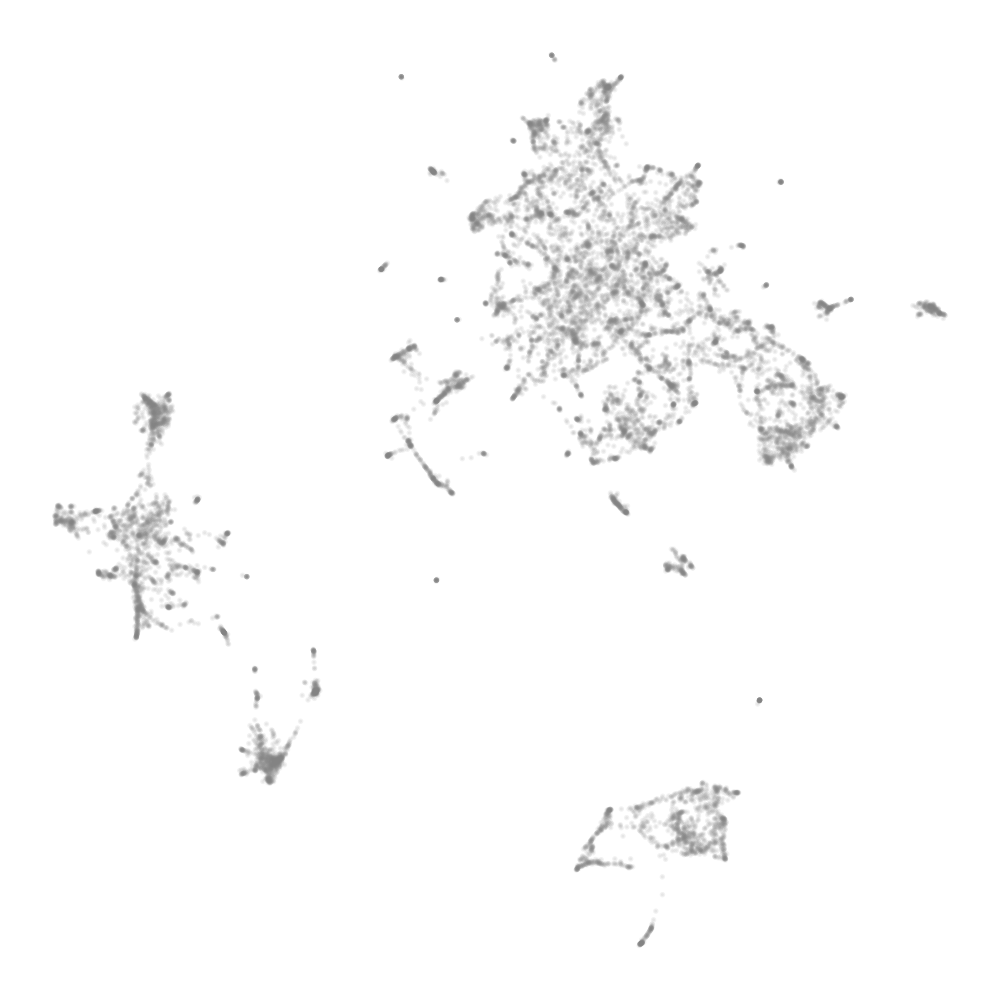

In [25]:
plot = (
    ggplot(df_lsreft, aes(x="x", y="y")) +
    geom_point(color="grey", alpha=0.1, size=0.1) +
    theme_minimal() +
    theme(
        axis_text=element_blank(), axis_title=element_blank(),
        panel_grid=element_blank(), legend_position="none",
        figure_size=(5, 5)
    )
)
plot.show()